# Notebook Goal
- divide light curves into epochs and calculate base num and stdev ratio for each epoch to determine which sources move around plot (i.e. transition)
- only certain movements qualify as transitions
# Predicted Difficulties
- how to cut 
    - starting with by OGLE epoch
- non-transition sources also moving around

In [1]:
from uncertainties import ufloat
from uncertainties.umath import *
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.stats import LombScargle
from scipy import signal
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.optimize
import glob
from astropy.table import Table,join,vstack,unique
from importlib import reload
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sb
import scipy.stats as st
import wotan

import ogle as o #module

blue = 'cornflowerblue'
navy = 'navy'
purple = 'rebeccapurple'
pink = '#CF6275'
maroon = 'maroon'

cross = Table.read('sourcefiles.csv')
full = Table.read('smc_x_m03_zar_match_OGLE_v2.ascii',format='ascii')

summ = pd.read_csv('summtab.csv')
alls = pd.read_csv('allsummtab.csv') #most updated table

cross['Part'] = 1
cross2 = Table.read('part2files.csv')
cross2 = join(cross2,full,keys='src_n')
cross2['Part'] = 2

mlist2 = ['OII I','OIII I','OIV I']
mlist1 = ['OII I','OIII I']

srcns = np.array(alls['src_n'])
#saving figure function
def sf(name,dpi=150):
    plt.savefig(f'Figs/{name}.png',bbox_inches='tight',dpi=dpi)
#simple plotting function
def plot(s,calib=False,both=True):
    try:band = o.getIV(s,cross,both=both,stack=True,plot=True,mlist=mlist1,figsize=(4,3),calib=calib)
    except:band = o.getIV(s,cross2,both=both,stack=True,plot=True,mlist=mlist2,figsize=(4,3),calib=calib)

In [40]:
#put type src nums into lists
type1 = o.gettype(alls,num='1')
type2 = o.gettype(alls,num='2')
type3 = o.gettype(alls,num='3')
type4 = [60,63]#o.gettype(alls,num='4')
type5 = o.gettype(alls,num='5')+o.gettype(alls,num='4')
type6 = o.gettype(alls,num='6')
type7 = o.gettype(alls,num='7')

#typet: transitioning sources
#save list of their type names
t_types = []
typet = []
for a in range(len(alls)):
    if '+' in str(alls.loc[a]['type']):
        typet.append(alls.loc[a]['src_n'])
        t_types.append(alls.loc[a]['type']) #e.g. '1+5'

In [71]:
def fulltplot(x='stdev I',y='det stdev I',legend=True,tbool=[False]*7,between=False,tab=alls):
    if between and len(tbool)==7: tbool.append(False) #make sure tbool is right length 
    o.tplot(type1,tab,color=pink,marker='*',label='1',x=x,y=y,text=tbool[0])
    o.tplot(type2,tab,color='black',label='2',x=x,y=y,text=tbool[1])
    o.tplot(type3,tab,color='black',marker='o',label='',x=x,y=y,text=tbool[2])
    o.tplot(type4,tab,color='rebeccapurple',marker='P',label='4',x=x,y=y,text=tbool[3])
    o.tplot(type5,tab,marker='v',label='5',color='maroon',x=x,y=y,text=tbool[4])
    o.tplot(type6,tab,marker='3',label='6',color='grey',x=x,y=y,text=tbool[5])
    o.tplot(type7,tab,color='darkseagreen',marker='h',label='7',x=x,y=y,text=tbool[6])
    #if between, also plot transition sources
    if between: o.tplot(typet,tab,marker='p',label='transition',color='navy',x=x,y=y,text=tbool[7])
    plt.ylabel(y,fontsize=14)
    plt.xlabel(x,fontsize=14)
    if legend: plt.legend()

In [72]:
#turn markers and colors into dictionary
tcolors = {1:pink,2:'black',3:'black',4:'rebeccapurple',5:'maroon',6:'grey',7:'darkseagreen','t':'navy'}
tmarkers = {1:'*',2:'o',3:'o',4:'P',5:'v',6:'3',7:'h','t':'p'}

### re-classification of typet sources that are really just ambiguous or interesting
- once done, nothing really in this section but leaving the record

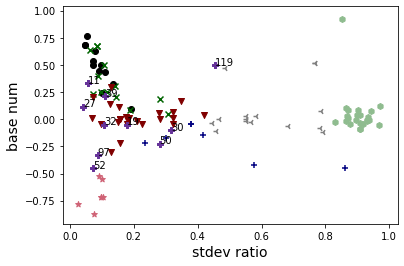

In [54]:
#remember goal is to replace stdev ratio with new ratio from other notebook
fulltplot(x='stdev ratio',y='base num',between=True,tbool=[False,False,False,False,False,False,False,True],legend=False)

In [55]:
row = alls[alls['src_n']==14]

In [16]:
row['stdev ratio']

12    0.101476
Name: stdev ratio, dtype: float64

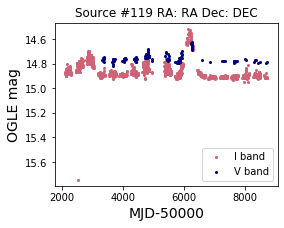

In [19]:
plot(119)

ambiguous rather than transitioning sources: 2, 10, 14 & 30, 34, 73, 119
- not re-classifying 30 for now
    - could just be type 5 but does have thousands of days of quiescence and a potential faint base
- also not re-classifying 119

In [15]:
#function for dividing LC by OGLE epoch and then getting separate base num and stdev ratios
def epochtype(s,plotlc=False,calib=False,printall=False,plot=False,annotate=False,marker='o',color='black',cuttype='epoch',time=False,period=False,retmed=False):
    '''cuttype: currently supports epoch or a number representing the number of cuts
    retmed: return list of medians, 3rd max, and 3rd min for each chunk '''
    #establish method for cutting:
    if cuttype=='epoch': 
        try:ilist = o.getIV(s,cross,both=False,stack=False,plot=plotlc,mlist=mlist1,figsize=(4,3),calib=calib)
        except:ilist = o.getIV(s,cross2,both=False,stack=False,plot=plotlc,mlist=mlist2,figsize=(4,3),calib=calib)    
    else: 
        timesplit,imagsplit,splinesplit,trendsplit = o.cut(s,cross,cross2,mlist1,mlist2,cut=cuttype,npoints=False,time=time,calib=calib,plot=plotlc,retsplit=True,window=200,old=True)
        #loop through cuts and put back into iband tables
        ilist = []
        for i in range(len(timesplit)):
            #temp table
            ttab = Table()
            ttab['MJD-50000'] = timesplit[i]
            ttab['I mag'] = imagsplit[i]
            ilist.append(ttab)
    #initiate lists for base nums and stdev ratios
    bns,sratios,imeds,imins,imaxs = [],[],[],[],[]
    if printall: print(f'number of OGLE epochs: {len(iband)}')
    for i in ilist:
        #detrend
        o.splinedetrend(i,window=200)
        mean = np.mean(i['I mag'])
        #also do sigma clip for detrending outliers
        sig = np.std(i['I detrend']) #try sigma clip instead
        med = np.median(i['I detrend'])
        i['I detrend'][i['I detrend']<med-2*sig] = mean
        #get overall stdev and detrended stdev
        ostd = np.std(i['I mag'])
        dstd = np.std(i['I detrend'])
        sratios.append(dstd/ostd)
        
        #get base num using third highest and lowest points
        i_list = list(i['I mag'])
        isort = sorted(i_list)
        maxi = isort[-3]
        mini = isort[2]
        medi = np.median(i['I mag'])
        imeds.append(medi)
        basenum = (maxi-medi)-(medi-mini)
        bns.append(basenum)
        imins.append(mini)
        imaxs.append(maxi)
    #if plot, show both points with source labels on base num vs. stdev ratio
    if plot:
        if period: plt.figure(figsize=(5,4))#need to make new figure here in case function called again
        plt.scatter(sratios,bns,marker=marker,color=color)
        #annotate
        if annotate: 
            for i in range(len(sratios)): plt.text(sratios[i],bns[i]+.01,str(s))
        #plot arrow with change(s)
        for i in range(len(sratios)-1):
            plt.arrow(sratios[i],bns[i],sratios[i+1]-sratios[i],bns[i+1]-bns[i],color=color,alpha=0.3,length_includes_head=True,head_width=0.02)
            
    if period: #do period search in each cut
        #get best auto det pd from table
        row = alls[alls['src_n']==s]
        autobp = float(row['best auto det pd'])
#         print(f'best auto det pd: {autobp:.2f}')
        bps,bpow = [],[]
        if plot: plt.figure(figsize=(5,4))
        colors = [pink,purple,blue,'darkseagreen','darkgreen','navy','maroon']
        c = 0
        for i in ilist:
            #first try searching between 2 and 200
            if autobp<200: 
                freq,power,bp = o.periodogram(i,minp=5,maxp=200,plot=False,more=True,det=True)
                if plot:
                    plt.plot(1/freq,power,color=colors[c],label=f'cut {c+1}')
            else: 
                freq,power,bp = o.periodogram(i,minp=autobp-200,maxp=autobp+200,plot=False,more=True,det=False)
                if plot:plt.plot(1/freq,power,color=colors[c],label=f'cut {c+1}')
            if plot: plt.axvline(autobp,color='grey',alpha=0.2)
            bps.append(float(bp))
            bpow.append(float(np.max(power)))
            c+=1
        if plot: plt.legend()
        if retmed:return bps,bpow,bns,sratios,imeds,imins,imaxs
        else: return bps,bpow,bns,sratios
    if retmed:bns,sratios,imeds,imins,imaxs
    else: return bns,sratios    

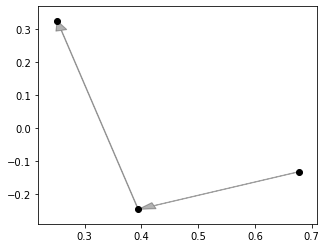

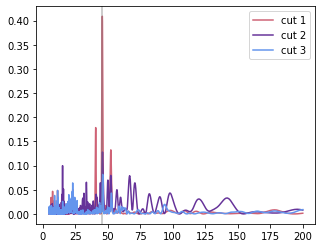

In [6]:
# test of period argument
bps,bpow,bns,sratios = epochtype(50,period=True,cuttype=3,plot=True)

In [44]:
bpow

[0.4090457339369698, 0.12795829033554942, 0.08173017468153888]

# saving transition info with 3 cuts to copy of alls
- save list of base nums, list of stdev ratios, list of best periods, and list of powers
    - may need to follow up on periodicity or range of search
- keep in mind non-constant amount of time

In [6]:
acopy = alls.copy()

In [7]:
len(srcns)

108

In [24]:
allbps = []
allbpow = []
allbns = []
allsrats = []
allmeds = []
allmins = []
allmaxs = []
for s in srcns:
    try: bps,bpow,bns,sratios,meds,mins,maxs = epochtype(s,period=True,cuttype=3,plot=False,retmed=True)
    except: bps,bpow,bns,sratios,meds,mins,maxs = np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan
    allbps.append(bps);allbpow.append(bpow);allbns.append(bns);allsrats.append(sratios);allmeds.append(meds);allmins.append(mins);allmaxs.append(maxs)

empty file for OIII I
empty file for OII I
empty file for OIII I


In [25]:
#add lists to copy of table
acopy['cut bps'] = allbps
acopy['cut bpows'] = allbpow
acopy['cut bns'] = allbns
acopy['cut sratios'] = allsrats
acopy['cut meds'] = allmeds
acopy['cut mins'] = allmins
acopy['cut maxs'] = allmaxs

In [26]:
for t in typet:
    row = acopy[acopy['src_n']==t]
    print(list(row['cut bps']))
#     print(list(row['cut bpows']),'\n')

[[28.525711313493282, 111.57197783269088, 14.666057504157006]]
[[28.52739893057011, 100.58464170100784, 5.824400325451167]]
[[486.0388897768317, 323.95718384579067, 322.9318964614259]]
[[14.96814017080262, 71.31018263111757, 29.14170994992972]]
[[45.8801845085868, 46.03676962276091, 46.181129074165206]]
[[23.596702632383593, 100.47061892332081, 59.61374463283997]]
[[77.98499935565451, 59.14751687858469, 64.86985273125971]]


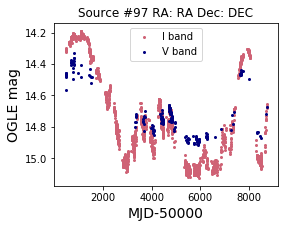

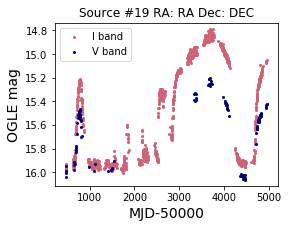

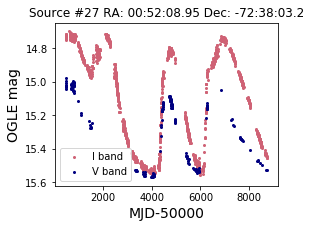

In [27]:
#steadiest periodicity,even with wide search range
plot(typet[6]) #21.9
plot(typet[1]) #39.8
plot(typet[-5]) #46

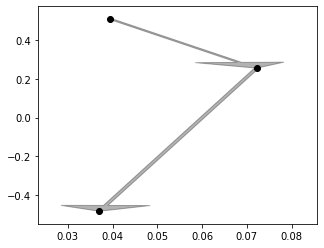

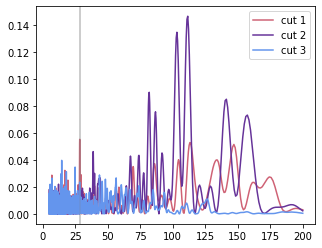

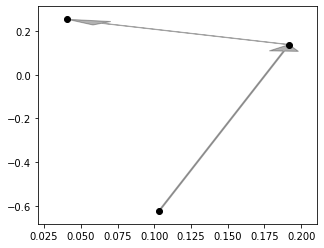

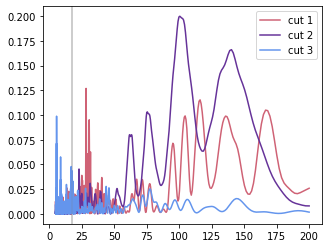

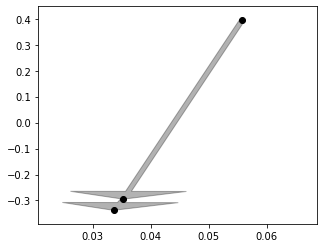

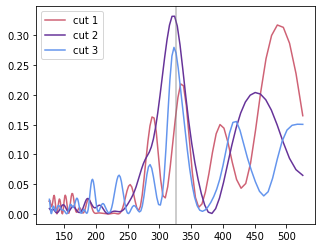

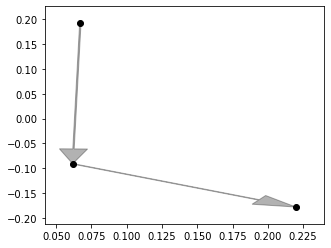

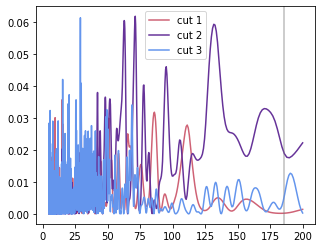

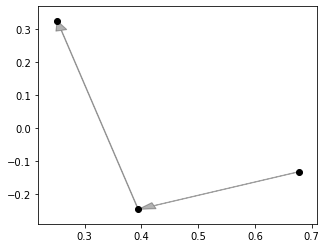

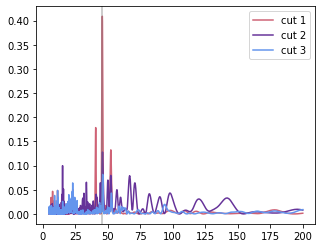

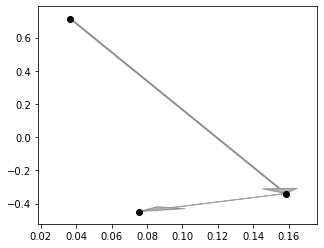

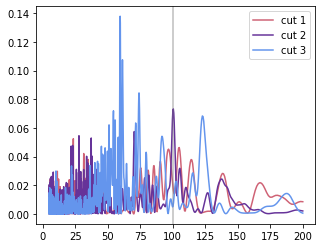

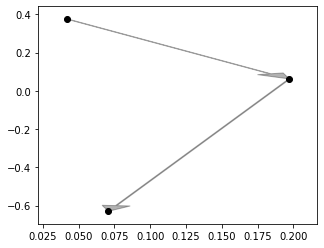

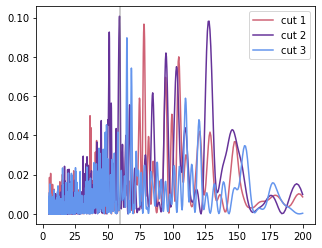

In [28]:
#get actual periodograms:
for t in typet:
    bps,bpow,bns,sratios = epochtype(t,period=True,cuttype=3,plot=True)

### any significance to
- vectors of transition types vs. others
- specific values for transition types vs. others

if not, 
- go back to method of searching for specific transitions
- can also check for another dimension in cut

In [29]:
row = acopy[acopy['src_n']==typet[0]]

In [30]:
np.array(row['cut sratios'])[0]

[0.03949702006197351, 0.07220999976519048, 0.03703024604126432]

(-1, 1)

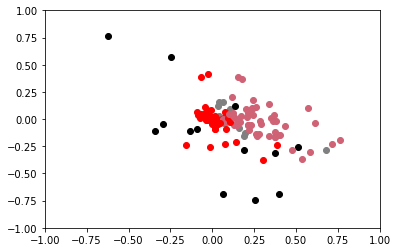

In [31]:
for t in typet:
    row = acopy[acopy['src_n']==t]
    rbns = np.array(row['cut bns'])[0]
    rsr = np.array(row['cut sratios'])[0]
    plt.scatter(rbns[0],rbns[1]-rbns[0],color='black')
    plt.scatter(rsr[0],rsr[1]-rsr[0],color='grey')
    plt.scatter(rbns[1],rbns[2]-rbns[1],color='black')
    plt.scatter(rsr[1],rsr[2]-rsr[1],color='grey')
for t in type5:
    row = acopy[acopy['src_n']==t]
    rbns = np.array(row['cut bns'])[0]
    rsr = np.array(row['cut sratios'])[0]
    plt.scatter(rbns[0],rbns[1]-rbns[0],color='red')
    plt.scatter(rsr[0],rsr[1]-rsr[0],color=pink)
    plt.scatter(rbns[1],rbns[2]-rbns[1],color='red')
    plt.scatter(rsr[1],rsr[2]-rsr[1],color=pink)
plt.xlim(-1,1)
plt.ylim(-1,1)

Text(0, 0.5, 'changes along base num and stdev ratio')

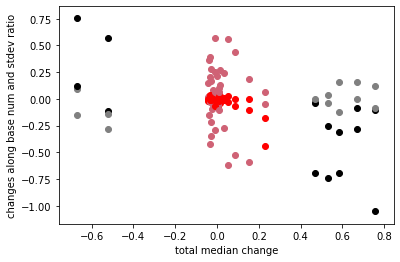

In [32]:
#now include changing medians
for t in typet:
    row = acopy[acopy['src_n']==t]
    rbns = np.array(row['cut bns'])[0]
    rsr = np.array(row['cut sratios'])[0]
    rmed = np.array(row['cut meds'])[0]
    #total median change
    totmed = rmed[1]-rmed[0] + (rmed[2]-rmed[1])
    plt.scatter(totmed,rbns[1]-rbns[0],color='black')
    plt.scatter(totmed,rsr[1]-rsr[0],color='grey')
    plt.scatter(totmed,rbns[2]-rbns[1],color='black')
    plt.scatter(totmed,rsr[2]-rsr[1],color='grey')
for t in type7:
    row = acopy[acopy['src_n']==t]
    rbns = np.array(row['cut bns'])[0]
    rsr = np.array(row['cut sratios'])[0]
    rmed = np.array(row['cut meds'])[0]
    #total median change
    totmed = rmed[1]-rmed[0] + (rmed[2]-rmed[1])
    plt.scatter(totmed,rbns[1]-rbns[0],color='red')
    plt.scatter(totmed,rsr[1]-rsr[0],color=pink)
    plt.scatter(totmed,rbns[2]-rbns[1],color='red')
    plt.scatter(totmed,rsr[2]-rsr[1],color=pink)
# plt.xlim(-1,1)
# plt.ylim(-1,1)
plt.xlabel('total median change')
plt.ylabel('changes along base num and stdev ratio')

In [33]:
tmetric = [] #try to make metric combining all these differences
meddiff = []
sdiff = []
mindiff = []
maxdiff = []
bndiff = []
for t in srcns:
    metric = 0
    row = acopy[acopy['src_n']==t]
    rbns = np.array(row['cut bns'])[0]
    rsr = np.array(row['cut sratios'])[0]
    rmed = np.array(row['cut meds'])[0]
    rmin = np.array(row['cut mins'])[0]
    rmax = np.array(row['cut maxs'])[0]
    
    try:
        md = np.abs(rmed[1]-rmed[0] + (rmed[2]-rmed[1]))
        sd = np.abs(rsr[1]-rsr[0] + (rsr[2]-rsr[1]))
        mind = np.abs(rmin[1]-rmin[0] + (rmin[2]-rmin[1]))
        maxd = np.abs(rmax[1]-rmax[0] + (rmax[2]-rmax[1]))
        metric += md
        bd = np.abs(rbns[1]-rbns[0] + (rbns[2]-rbns[1]))
        metric += bd
        metric += sd
    except: metric = np.nan; md = np.nan; sd = np.nan; mind = np.nan; maxd = np.nan; bd = np.nan
    tmetric.append(metric); meddiff.append(md); sdiff.append(sd); mindiff.append(mind); maxdiff.append(maxd); bndiff.append(bd)

(0, 3)

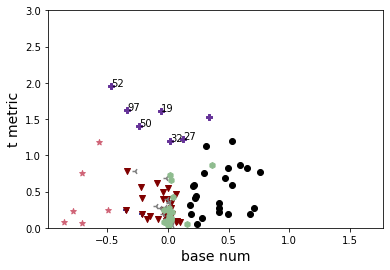

In [45]:
acopy['t metric'] = tmetric
fulltplot(x='base num',y='t metric',between=True,legend=False,tbool=[False,False,False,False,False,False,False,True],tab=acopy)
plt.ylim(0,3)

- notice between plot below and above that the total metric isn't really an improvement on just the median difference
- fine with some typet sources not being labeled as transition sources since they're ambiguous for other reasons
- just check how many are false negatives right now by eye
- **these comments may not make sense now that table types reflect results from this notebook**

In [35]:
row = acopy[acopy['src_n']==39]
row['t metric']

34    0.58429
Name: t metric, dtype: float64

(-1, 1)

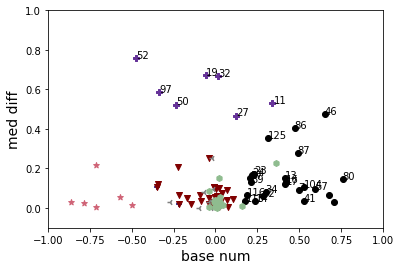

In [50]:
acopy['med diff'] = meddiff
fulltplot(x='base num',y='med diff',between=True,legend=False,tbool=[False,True,True,False,False,False,False,True],tab=acopy)
plt.ylim(-.1,1)
# sf('meddiff')
plt.text(0.35,0.53,'11')
plt.xlim(-1,1)


(-1, 1)

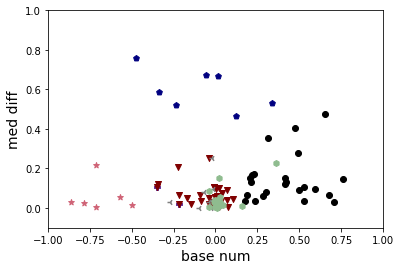

In [76]:
#version to save
fulltplot(x='base num',y='med diff',between=True,legend=False,tbool=[False,False,False,False,False,False,False,False],tab=acopy)
plt.ylim(-.1,1)
plt.xlim(-1,1)
# sf('meddiff')

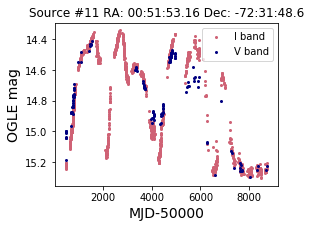

In [68]:
plot(11)

In [57]:
acopy[acopy['src_n']==53]['med diff']

47    0.078
Name: med diff, dtype: float64

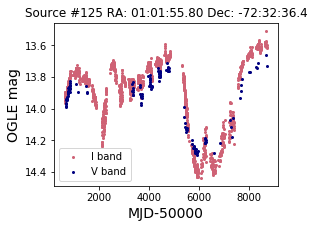

In [55]:
plot(125)

In [37]:
typet

[11, 19, 27, 32, 50, 52, 97]

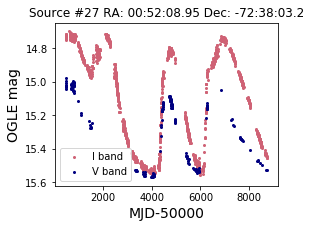

In [90]:
plot(27)

how many false negatives using median difference
- list ones that aren't transitioning, but just otherwise ambiguous (i.e., that's why they don't have high med diff)
    - 2, 10, 14 & 30 (check timescales; just have good chunk of quiescence), 34, 73, 119
    - often ambiguous just b/c of wider features/longer timescale, so want to check their spins (not that high according to number) and optical period
- false negatives
    - 39: median is decreasing (brightening) in three chunks, but may not change much in second and third
        - idea: normalize by standard deviation, or add change in stdev? decently high in t metric but still false neg
        - so can add new quantity or try t metric without change in base num

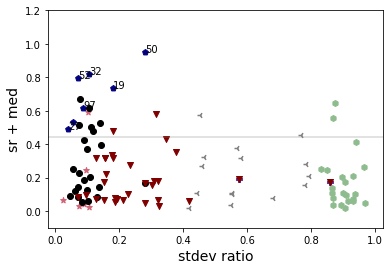

In [77]:
acopy['sr diff'] = sdiff 
acopy['bn diff'] = bndiff 

acopy['sr + med'] = acopy['sr diff']+acopy['med diff'] 
fulltplot(x='stdev ratio',y='sr + med',between=True,legend=False,tbool=[False,False,False,False,False,False,False,True],tab=acopy)
plt.ylim(-.1,1.2)
plt.axhline(0.44,color='grey',alpha=0.3)

In [80]:
srmedcut = acopy[acopy['sr + med']>0.44]
srmedcut = srmedcut[srmedcut['stdev ratio']<0.6]

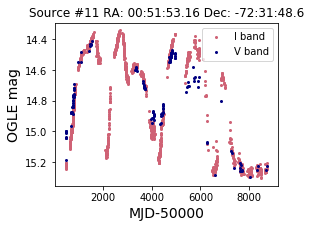

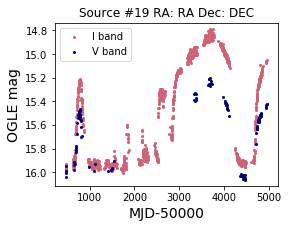

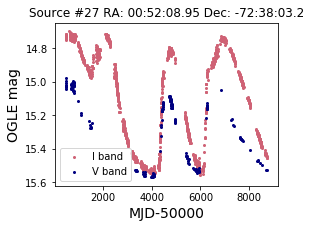

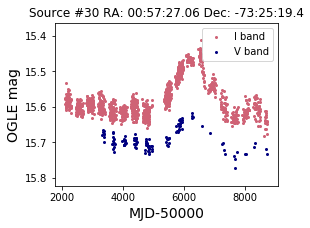

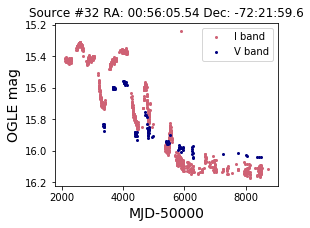

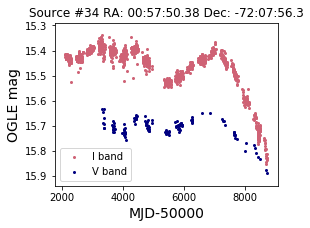

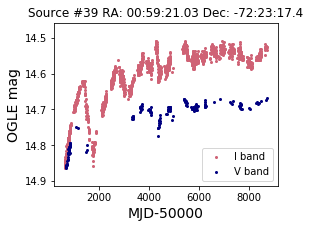

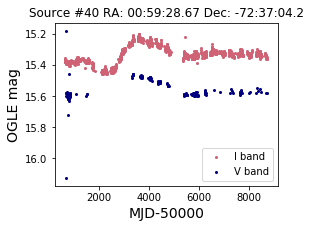

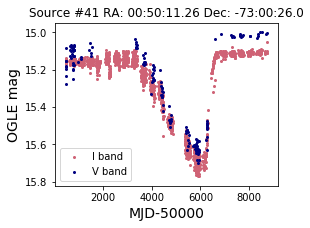

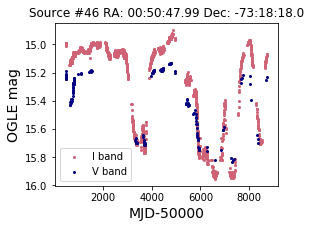

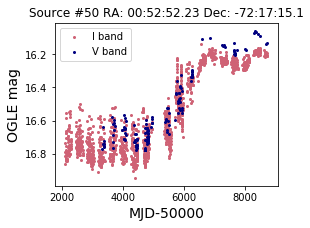

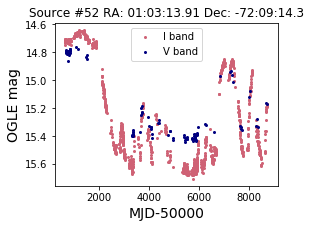

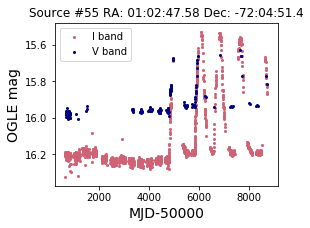

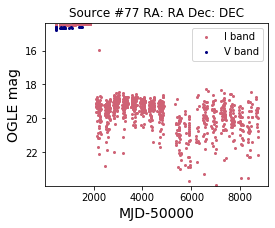

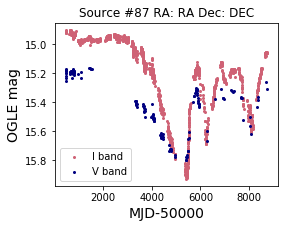

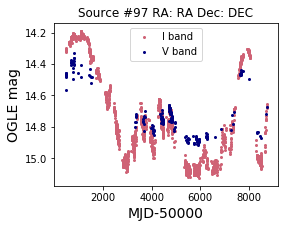

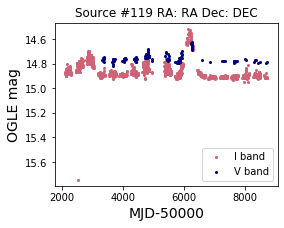

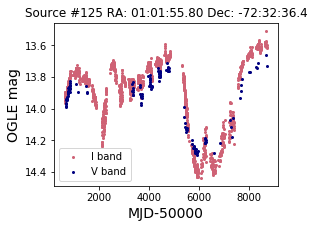

In [81]:
#just a few false positives that could be taken out by-eye
# for s in srmedcut['src_n']:
#     plot(s)

(-0.1, 0.8)

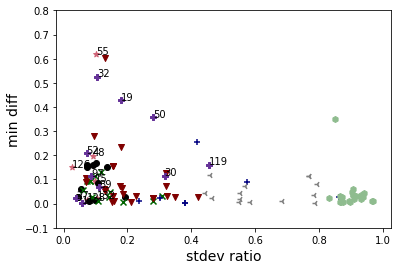

In [71]:
#looking at just change of min
acopy['min diff'] = mindiff

fulltplot(x='stdev ratio',y='min diff',between=True,legend=False,tbool=[True,False,False,False,False,False,False,True],tab=acopy)
plt.ylim(-.1,0.8)

(-0.1, 0.9)

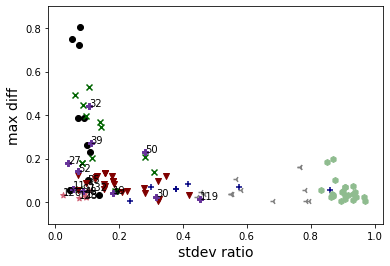

In [72]:
#looking at just max diff
#of course some dippers have broader range
acopy['max diff'] = maxdiff

fulltplot(x='stdev ratio',y='max diff',between=True,legend=False,tbool=[True,False,False,False,False,False,False,True],tab=acopy)
plt.ylim(-.1,.9)

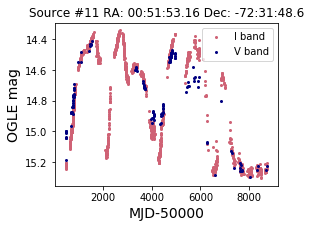

In [73]:
plot(11)

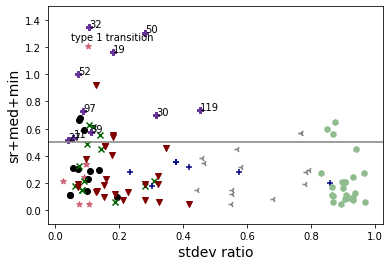

In [107]:
acopy['sr+med+min+max'] =  acopy['sr diff'] + acopy['med diff'] + acopy['min diff'] + acopy['max diff']
acopy['sr+med+min'] =  acopy['sr diff'] + acopy['med diff'] + acopy['min diff'] #+ acopy['max diff']
acopy['sr+med+min+bn'] =  acopy['sr diff'] + acopy['med diff'] + acopy['min diff'] + acopy['bn diff']

fulltplot(x='stdev ratio',y='sr+med+min',between=True,legend=False,tbool=[False,False,False,False,False,False,False,True],tab=acopy)
plt.ylim(-.1,1.5)
plt.axhline(0.5,color='grey')
plt.text(0.05,1.25,'type 1 transition')
# sf('sr+med+min')

In [97]:
srmmcut = acopy[acopy['sr+med+min']>0.5]
srmmcut = srmmcut[srmmcut['stdev ratio']<0.6]

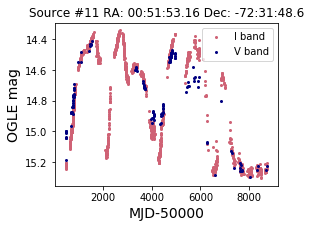

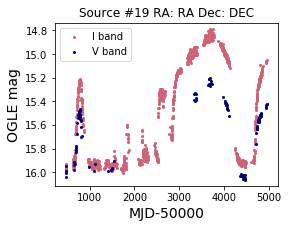

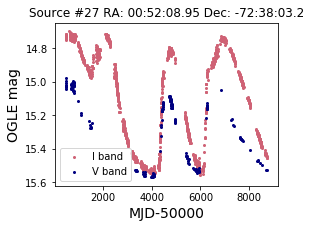

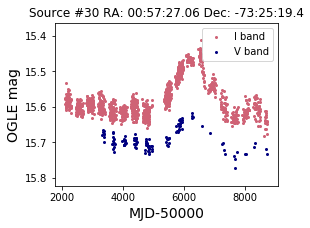

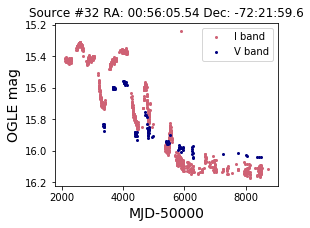

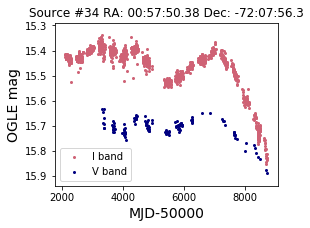

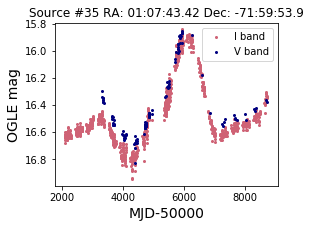

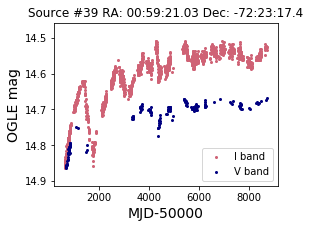

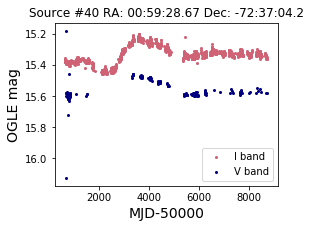

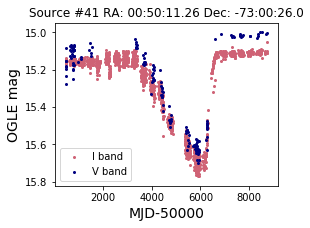

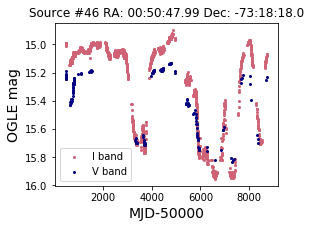

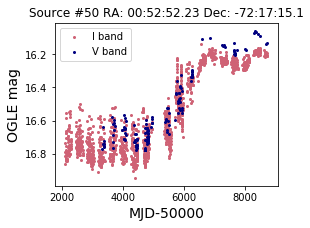

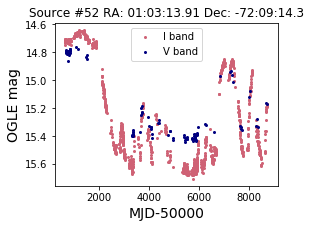

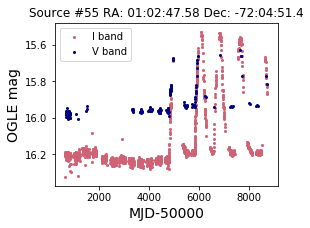

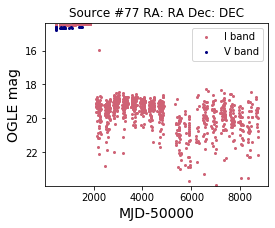

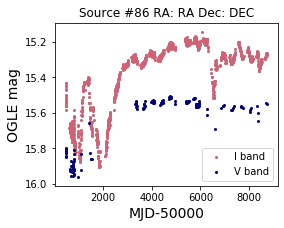

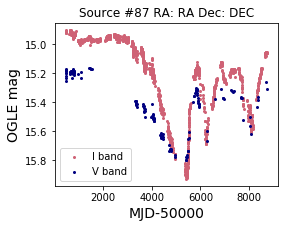

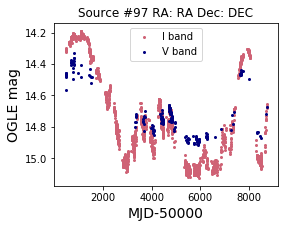

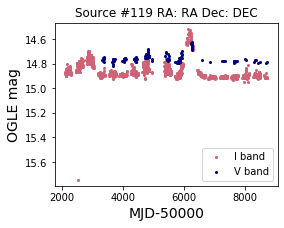

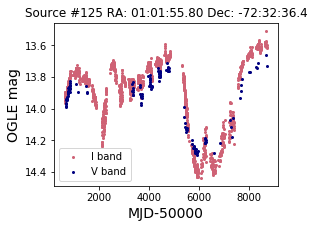

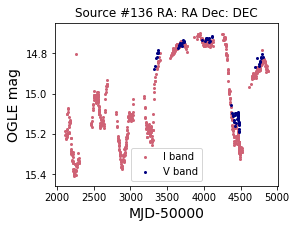

In [98]:
for s in srmmcut['src_n']:
    plot(s)

(-0.1, 1.5)

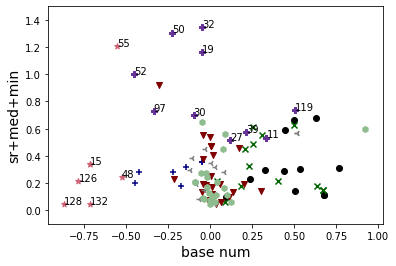

In [75]:
#same plot vs. base num
fulltplot(x='base num',y='sr+med+min',between=True,legend=False,tbool=[True,False,False,False,False,False,False,True],tab=acopy)
plt.ylim(-.1,1.5)

(-0.1, 2.5)

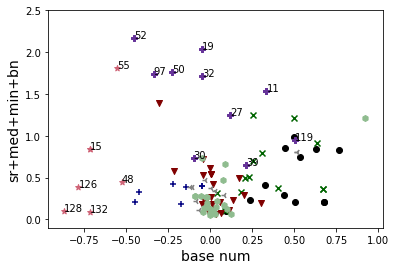

In [76]:
#including base num diff
fulltplot(x='base num',y='sr+med+min+bn',between=True,legend=False,tbool=[True,False,False,False,False,False,False,True],tab=acopy)
plt.ylim(-.1,2.5)

In [100]:
# look at sources above sr + med of 
sm = acopy[acopy['sr + med']>0.4]

In [101]:
sm[2:3]

,src_n,ra_deg,dec_deg,spin period,perr,est. period,sep,name,mean I,stdev I,...,t metric,med diff,sr diff,bn diff,sr + med,min diff,max diff,sr+med+min+max,sr+med+min,sr+med+min+bn
22,25,16.802626,-72.59272,65.78,0.87,110.6,0.295919,NaN,15.915777,0.055598,...,0.687851,0.2545,0.198351,0.235,0.452851,0.113,0.161,0.726851,0.565851,0.800851


In [102]:
tmarkers

{1: '*', 2: 'o', 3: 'x', 4: '+', 5: 'v', 6: '3', 7: 'h', 't': 'P'}

Text(0, 0.5, 'I skew')

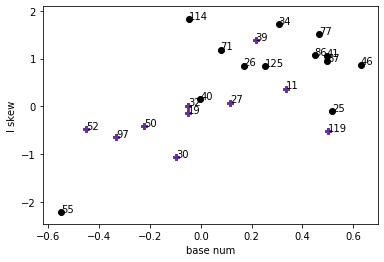

In [103]:
#look for space within which median-divided transition sources can be separated from false positives
# plt.scatter(sm['stdev ratio'],sm['base num'],color='black')
for s in range(1,len(sm)):
    row = sm[s-1:s]
    xname = 'base num'
    yname = 'I skew'
    x = float(row[xname])
    y = float(row[yname])
    if int(row['src_n']) in typet:
        plt.scatter(x,y,color='rebeccapurple',marker=tmarkers['t'])
    else:
        plt.scatter(x,y,color='black')


    plt.text(x,y,str(int(row['src_n'])))
plt.xlabel(xname)
plt.ylabel(yname)

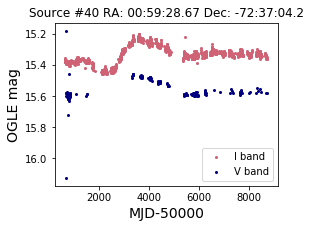

In [104]:
plot(40)

empty file for OIII I


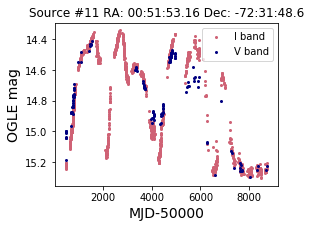

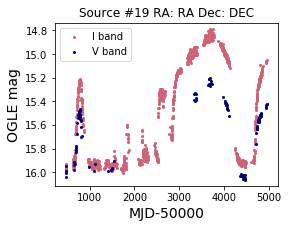

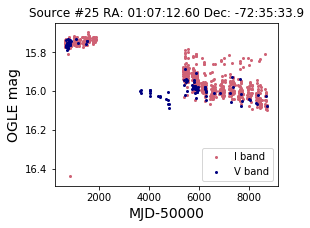

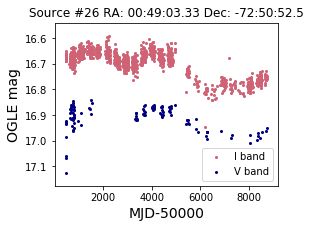

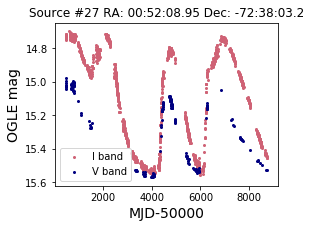

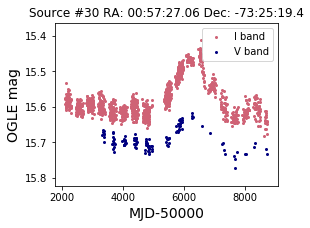

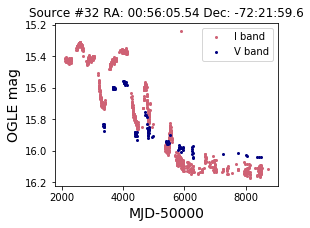

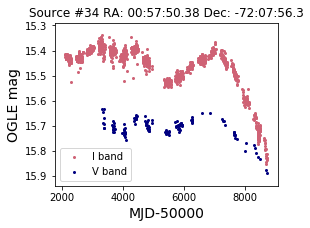

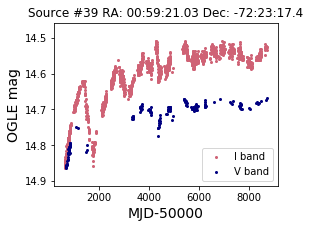

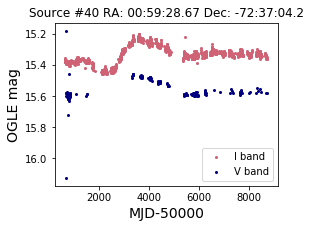

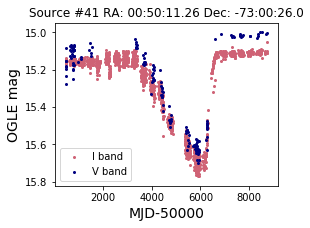

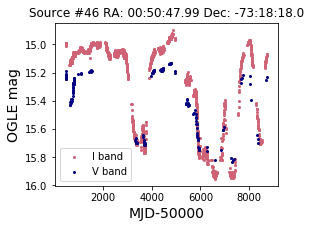

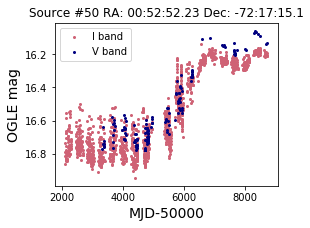

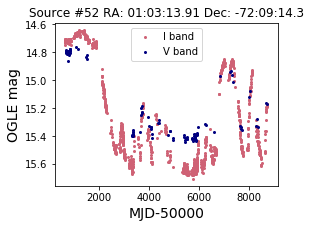

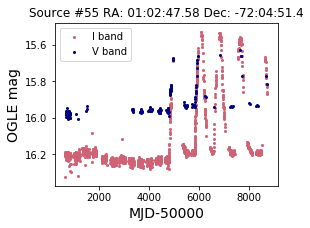

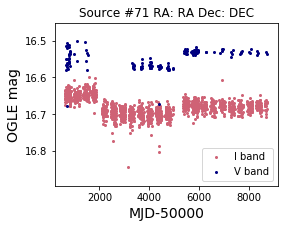

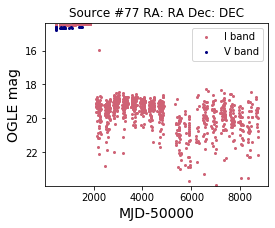

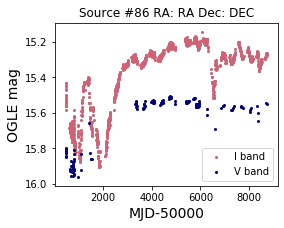

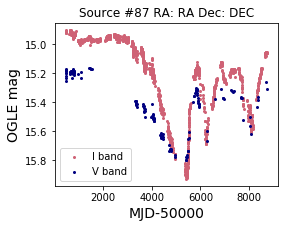

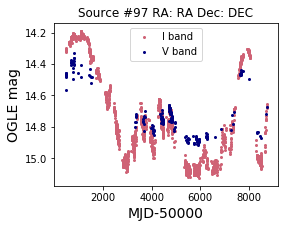

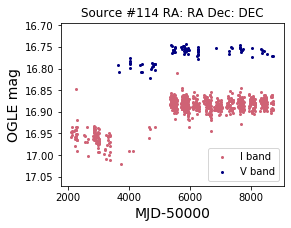

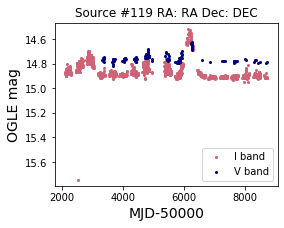

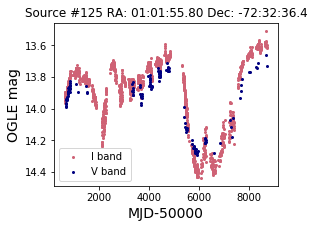

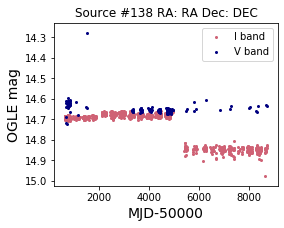

In [22]:
#would basically want to get rid of these false positives by excluding types 2 and 3 (high base num) and 6 and 7 (high stdev ratio)
for s in sm['src_n']: #41,46,86,87 are false positives
    plot(s)

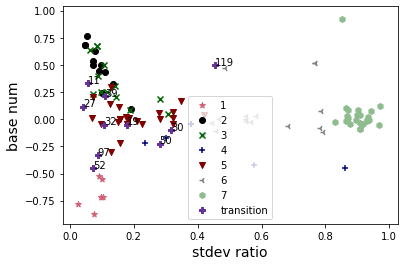

In [108]:
fulltplot(x='stdev ratio',y='base num',between=True,tbool=[False,False,False,False,False,False,False,True])

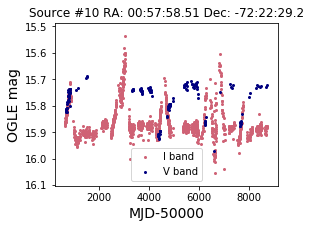

In [8]:
plot(10) #type 4? type 5? some similarity with type 1

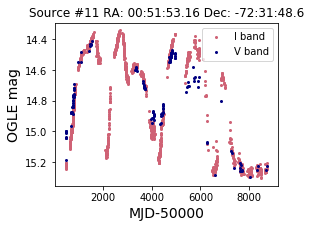

In [9]:
#3 cuts recognize (for this higher variability) that there's both a faint and bright base
plot(11)

look specifically for these transitions:
- into or out of type 1 region, as in e.g., 19
- high variability but between opposite base nums -- can mean there's both faint and bright?
- with >3 cuts, can catch the slow move to quiescence from e.g., 32 (~5 cuts)
    - 39 shown in 3 cuts

In [78]:
def type1t(s,plot=False,marker='o',color='black',cuttype=3,time=False):
    '''check a source for a transition to or from type 1'''
    bns,srs = epochtype(s,plot=plot,marker=marker,color=color,annotate=True,cuttype=cuttype,time=time)
    bns = np.array(bns)
    srs = np.array(srs)
    t1b = bns[bns<-0.4]
    srs = srs[srs<0.2]
    if len(t1b)>0 and len(srs)>0: return True
    else: return False

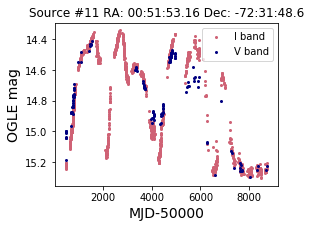

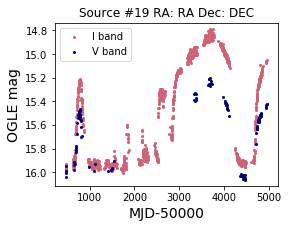

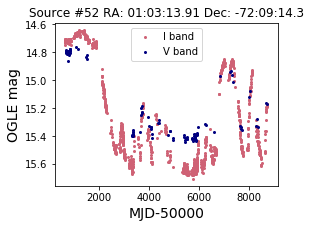

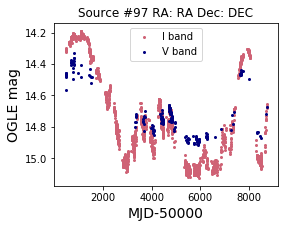

In [79]:
for t in typet:
    if type1t(t):plot(t)

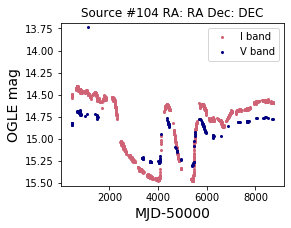

In [80]:
for t in type2:
    if type1t(t):plot(t)

In [85]:
#none others from other types, at least with this cut
for t in type7:
    if type1t(t):plot(t)

empty file for OII I


In [14]:
def type6t(s,mono=False,plot=False,marker='o',color='black',cuttype=3,time=False):
    '''checks for a (monotonic) increase or decrease in stdev ratio, which crosses in and out of type 6'''
    bns,srs = epochtype(s,plot=plot,marker=marker,color=color,annotate=True,cuttype=cuttype,time=time)
    bns = np.array(bns)
    srs = np.array(srs)
    t6b = bns[np.abs(bns)<.2] #not super important condition
    sr6 = srs[srs>0.4]
    ret = len(t6b)>0 and len(sr6)>0
    if mono:
        if not o.monotonic(srs):ret=False 
    return ret

In [186]:
t6t = [55,32,30,39,50,119,10,11,14,19,34,73]

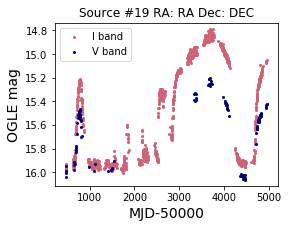

In [191]:
plot(19)

In [193]:
for t in t6t:
    if type6t(t,time=False,cuttype=3):print(t)

55
30
39
50
119
34


there are, by definition, quiescent periods in type 3 sources

sources in each type that are passing "transition in/out of type 6 test"
- type1: 55
- type2: none
- see above, but 21, 41 for type3
- type4: 5
- and of course a bunch of type 5
- transition sources: 30,34,39,50,119
    - only significant if these sources are, on the whole, in type2, type1
- so now looking for monotonic changes (should give 2-3 sources)

In [208]:
for t in typet:
    if type6t(t,time=False,cuttype=3):print(t)

30
34
39
50
119


(0, 0.9)

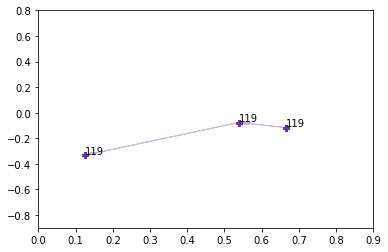

In [178]:
for t in [119]:
    epochtype(t,plot=True,marker='P',color='rebeccapurple',annotate=True,cuttype=3,time=False)
plt.ylim(-.9,.8)
plt.xlim(0,.9)

(0, 0.9)

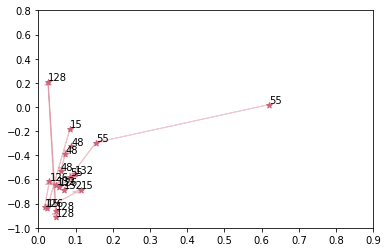

In [158]:
for t in type1:
    epochtype(t,plot=True,color=pink,marker='*',annotate=True,cuttype=3)
plt.ylim(-1,.8)
plt.xlim(0,.9)

(0, 0.9)

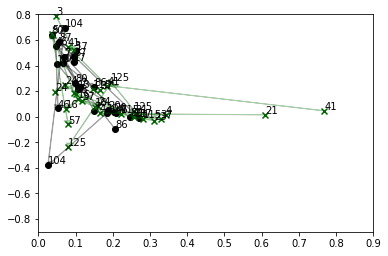

In [75]:
for t in type2:
    epochtype(t,plot=True,color=tcolors[2],marker=tmarkers[2],annotate=True)
for t in type3:
    epochtype(t,plot=True,color=tcolors[3],marker=tmarkers[3],annotate=True)
plt.ylim(-.9,.8)
plt.xlim(0,.9)

In [15]:
def typediff(typelist):
    bndiffs = []
    srdiffs = []
    for t in typelist: 
        bns,srs = epochtype(t)
        if len(bns)>1:
            bndiffs.append(np.max(bns)-np.min(bns))
            srdiffs.append(np.max(srs)-np.min(srs))        
    return bndiffs,srdiffs

In [16]:
bnt,srt = typediff(typet)
bn1,sr1 = typediff(type1)
bn5,sr5 = typediff(type5)

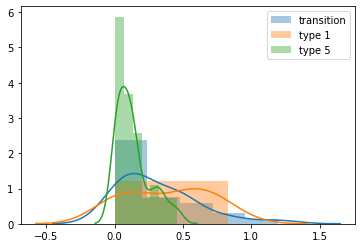

In [17]:
sb.distplot(bnt+srt,label='transition')
sb.distplot(bn1+sr1,label='type 1')
sb.distplot(bn5+sr5,label='type 5')
plt.legend()

### try distinguishing no base from base on both ends by fitting lines to some percentage of brightest points from each cut

In [22]:
def baseline(s,ncut=3,plot=False,calib=False):
    timesplit,imagsplit,splinesplit,trendsplit = o.cut(s,cross,cross2,mlist1,mlist2,cut=ncut,npoints=False,time=False,calib=calib,plot=plot,retsplit=True,window=200)
    #loop through cuts and put back into iband tables
    ilist = []
    for i in range(len(timesplit)):
        #temp table
        ttab = Table()
        ttab['MJD-50000'] = timesplit[i]
        ttab['I mag'] = imagsplit[i]
        ilist.append(ttab)
    #loop through to grab brightest and faintest points from each cut
    bright,faint = [],[] #initiate as lists and then vstack after loop
    for i in ilist:
        #brightest 5 percent
        b5 = np.max(i['I mag']) - st.iqr(i['I mag'],rng=[5,100])
        tempb = i[i['I mag']<b5]
        bright.append(tempb)
        #repeat for faintest 5 percent
        f5 = np.min(i['I mag']) + st.iqr(i['I mag'],rng=[0,95])
        tempf = i[i['I mag']>f5]
        faint.append(tempf)
    bright = vstack(bright)
    bright.sort(['MJD-50000'])
    faint = vstack(faint)
    faint.sort(['MJD-50000'])    
    return bright,faint

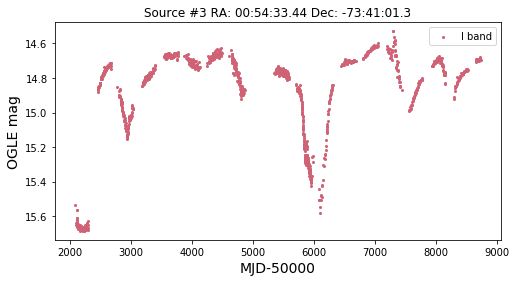

In [23]:
b,f = baseline(3,plot=True)

# V-I Phase-Folding for Src 50

In [3]:
iband,vband = o.getIV(50,cross,both=True,stack=True)

In [4]:
interp = o.colormag(iband,vband,retint=True,plot=False)

I and V-I correlation: -0.3076089999036358
V and V-I correlation: -0.14108535704213498


I band with detrending:45.924268366521595
I band without detrending:45.98787353043964


Text(56, 0.13, 'V-I detrending not good')

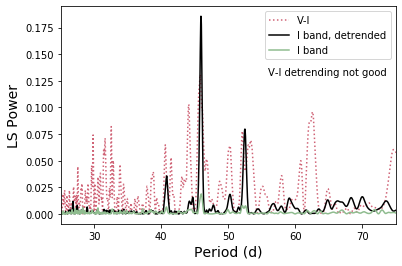

In [5]:
t = vband['MJD-50000']
y = vband['V mag'] - interp #y is V-I color
minp = 2
maxp = 200
minf = 1./maxp
maxf = 1./minp
ls = LombScargle(t, y)
freq, power = ls.autopower(normalization='standard',
                           minimum_frequency=minf,
                           maximum_frequency=maxf,
                           samples_per_peak=50)
#remember it's not detrended
#compare to normal I band periodogram (with detrending)
plt.plot(1/freq,power,color=pink,linestyle='dotted',label='V-I')
o.detrend(iband)
f,p,bp = o.periodogram(iband,minp=2,maxp=200,more=True,plot=False,det=True)
print(f'I band with detrending:{bp}')
plt.plot(1/f,p,color='black',label='I band, detrended')
f,p,bp = o.periodogram(iband,minp=2,maxp=200,more=True,plot=False,det=False)
print(f'I band without detrending:{bp}')
plt.plot(1/f,p,color='darkseagreen',label='I band')

#zooming in on region of strong period
plt.xlim(25,75)
plt.ylabel('LS Power',fontsize=14)
plt.xlabel('Period (d)',fontsize=14)
plt.legend()
plt.text(56,0.13,'V-I detrending not good')
# sf('src50pdgrams')

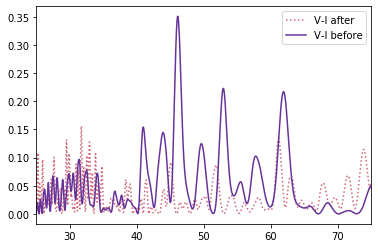

In [10]:
t = vband['MJD-50000'][100:]
y = vband['V mag'][100:] - interp[100:] #y is V-I color
minp = 2
maxp = 200
minf = 1./maxp
maxf = 1./minp
ls = LombScargle(t, y)
freq, power = ls.autopower(normalization='standard',
                           minimum_frequency=minf,
                           maximum_frequency=maxf,
                           samples_per_peak=50)
#remember it's not detrended
#compare to normal I band periodogram (with detrending)
plt.plot(1/freq,power,color=pink,linestyle='dotted',label='V-I after ')
t = vband['MJD-50000'][:100]
y = vband['V mag'][:100] - interp[:100] #y is V-I color
minp = 2
maxp = 200
minf = 1./maxp
maxf = 1./minp
ls = LombScargle(t, y)
freq, power = ls.autopower(normalization='standard',
                           minimum_frequency=minf,
                           maximum_frequency=maxf,
                           samples_per_peak=50)
plt.plot(1/freq,power,color=purple,label='V-I before')
plt.legend()
plt.xlim(25,75)
# sf('src50beforeafter')

In [112]:
#try detrending V band and interp
flatten, trend = wotan.flatten(vband['MJD-50000'],vband['V mag'],method='rspline',window_length=200,break_tolerance=50,return_trend=True)
#change nans to zeros -- but figure out way to ignore so as to not add false values to periodogram
trend[np.isnan(trend)] = 0
#add detrended column: original - trend + mean
mean = np.mean(vband['V mag'])
detr = vband['V mag'] - trend + mean
vband['V detrend'] = detr

flatten, trend = wotan.flatten(vband['MJD-50000'],interp,method='rspline',window_length=200,break_tolerance=50,return_trend=True)
#change nans to zeros -- but figure out way to ignore so as to not add false values to periodogram
trend[np.isnan(trend)] = 0
#add detrended column: original - trend + mean
mean = np.mean(interp)
detr = interp - trend + mean
vband['interp detrend'] = detr

vband['V-I detrend'] = vband['V detrend'] - vband['interp detrend']

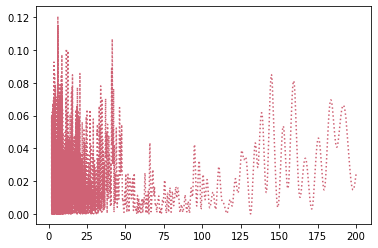

In [141]:
t = vband['MJD-50000']
y = vband['V-I detrend'] #y is V-I color
minp = 2
maxp = 200
minf = 1./maxp
maxf = 1./minp
ls = LombScargle(t, y)
freq, power = ls.autopower(normalization='standard',
                           minimum_frequency=minf,
                           maximum_frequency=maxf,
                           samples_per_peak=50)
#remember it's not detrended
#compare to normal I band periodogram (with detrending)
plt.plot(1/freq,power,color=pink,linestyle='dotted',label='V-I,scaled up')

In [123]:
#get best period from table
alls[alls['src_n']==50]['best auto det pd']
#try 45.9 and the value below

44    45.948523
Name: best auto det pd, dtype: float64

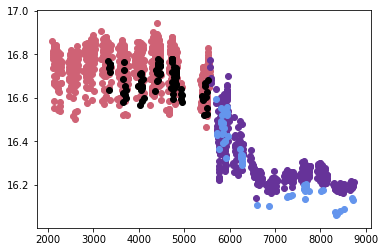

In [116]:
#now divide up before and after transition and phase-fold V-I
plt.scatter(iband['MJD-50000'][:900],iband['I mag'][:900],color=pink)
plt.scatter(iband['MJD-50000'][900:],iband['I mag'][900:],color=purple)

plt.scatter(vband['MJD-50000'][:100],vband['V mag'][:100],color='black')
plt.scatter(vband['MJD-50000'][100:],vband['V mag'][100:],color=blue)

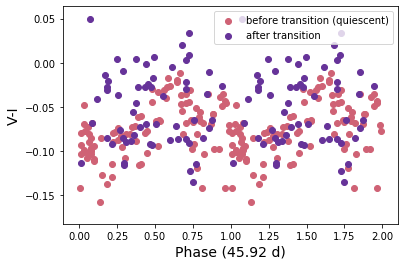

In [140]:
#phase fold each vi
bp = 45.924268366521595
#45.948523
plt.scatter((vband['MJD-50000'][:100]%bp)/bp,vband['V mag'][:100]-interp[:100],color=pink)
plt.scatter(1+(vband['MJD-50000'][:100]%bp)/bp,vband['V mag'][:100]-interp[:100],color=pink,label='before transition (quiescent)')

plt.scatter((vband['MJD-50000'][100:]%bp)/bp,vband['V mag'][100:]-interp[100:],color='rebeccapurple')
plt.scatter(1+(vband['MJD-50000'][100:]%bp)/bp,vband['V mag'][100:]-interp[100:],color='rebeccapurple',label='after transition')
plt.legend()
plt.ylabel('V-I',fontsize=14)
plt.xlabel(f'Phase ({bp:.2f} d)',fontsize=14)
sf('src50vifold')

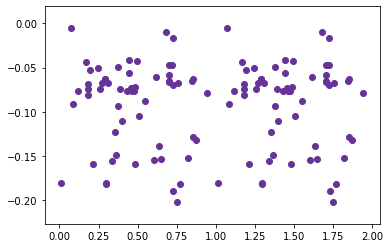

In [141]:
#repeat with step func
